Agatha Justina Majcher  
M.Sc. Renewable Energy Systems

# Distributional Analysis of the Carbon Tax in South Africa

Part II - PyPSA-ZA  
Revenue Recycling through Investment in Renewable Energies

# 1. Setup

In [1]:
import sys
sys.path.append("~/Desktop/pypsa-za-master")

In [2]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("bmh")
%matplotlib inline

In [3]:
import pandas as pd
import geopandas as gpd
import numpy
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
from vresutils import plot as vplot
from vresutils import Dict

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# setup for plots
colors = {
    "onwind": "#77D1E4",
    "hydro": "#004F95",
    "hydro-import": "#004F95",
    "CSP": "#FEED82",
    "solar": "#FFBB4E",
    "biomass": "#0c6013",
    "CCGT": "#CCC8C8",
    "OCGT": "#8D7867",
    "nuclear": "#C84936",
    "gas": "grey",
    "coal": "#3C3C3C",
}

nice_names = {
    'nuclear': 'Nuclear',
    'coal': 'Coal',
    'CCGT': 'CCGT',
    'OCGT': 'OCGT',
    'gas': 'Gas',
    'onwind': 'Wind',
    'hydro': 'Hydro',
    'hydro-import': 'Hydro Import',
    'solar': 'PV',
    'CSP': 'CSP',
    'biomass': 'Biomass',
}

In [21]:
# solved_network files

n0 = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-2190H_base.nc")
n1 = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-2190H_inv_1.nc") 
n2 = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-2190H_inv_2.nc")
n3 = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-Ep-2190H.nc")


INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-2190H_base.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-2190H_inv_1.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-2190H_inv_2.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-Ep-2190H.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [12]:
for c in n0.iterate_components(list(n0.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 27 entries
Component 'Carrier' has 12 entries
Component 'GlobalConstraint' has 17 entries
Component 'Line' has 120 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Load' has 27 entries
Component 'Generator' has 695 entries
Component 'StorageUnit' has 328 entries


# 2. Capacity

In [75]:
# Get capacities before optimization
capacities_before = n0.generators.groupby('carrier')['p_nom'].sum()

# Get capacities after optimization for each network
capacities_after_n0 = n0.generators.groupby('carrier')['p_nom_opt'].sum()
capacities_after_n1 = n1.generators.groupby('carrier')['p_nom_opt'].sum()
capacities_after_n2 = n2.generators.groupby('carrier')['p_nom_opt'].sum()
capacities_after_n3 = n3.generators.groupby('carrier')['p_nom_opt'].sum()

# Combine all the data into one DataFrame
all_networks_data = pd.concat([capacities_before, capacities_after_n0, capacities_after_n1, capacities_after_n2, capacities_after_n3], axis=1, keys=['Before', 'n0', 'n1', 'n2', 'n3'])
all_networks_data.columns.names = ['Capacity']

# Print or display the combined DataFrame
print(all_networks_data)

# Save to CSV
all_networks_data.to_csv('generator_capacities_by_carrier.csv')



Capacity            Before            n0            n1            n2  \
carrier                                                                
CCGT                  0.00  0.000000e+00  0.000000e+00  0.000000e+00   
CSP                 600.00  6.000000e+02  6.000000e+02  6.000000e+02   
OCGT                  0.00  1.415165e+03  1.415165e+03  1.415165e+03   
biomass             193.06  1.930600e+02  1.930600e+02  1.930600e+02   
coal              40284.00  4.028400e+04  4.028400e+04  4.028400e+04   
gas                3844.00  3.844000e+03  3.844000e+03  3.844000e+03   
hydro               683.02  6.830200e+02  6.830200e+02  6.830200e+02   
hydro-import       1764.00  1.764000e+03  1.764000e+03  1.764000e+03   
load_shedding  27000000.00  2.700000e+07  2.700000e+07  2.700000e+07   
nuclear            1854.00  1.854000e+03  1.854000e+03  1.854000e+03   
onwind             5190.59  1.329059e+04  1.329059e+04  1.329059e+04   
solar              4047.07  9.717070e+03  5.721751e+04  9.717070

# 3. Generation

In [70]:
sum_n0 = n0.generators_t.p.sum().groupby(n0.generators.carrier).sum()
sum_n1 = n1.generators_t.p.sum().groupby(n1.generators.carrier).sum()
sum_n2 = n2.generators_t.p.sum().groupby(n2.generators.carrier).sum()
sum_n3 = n3.generators_t.p.sum().groupby(n3.generators.carrier).sum()

df_n0 = sum_n0.reset_index().rename(columns={0: 'n0'})
df_n1 = sum_n1.reset_index().rename(columns={0: 'n1'})
df_n2 = sum_n2.reset_index().rename(columns={0: 'n2'})
df_n3 = sum_n3.reset_index().rename(columns={0: 'n3'})

combined_df = df_n0.merge(df_n1, on='carrier').merge(df_n2, on='carrier').merge(df_n3, on='carrier')


# Sum for each column
sum_row = combined_df.sum(numeric_only=True)
sum_row['carrier'] = 'SUM'
combined_df_with_sum = combined_df.append(sum_row, ignore_index=True)

print(combined_df_with_sum)

combined_df_with_sum.to_csv('combined_sums_with_total.csv', index=False)



          carrier             n0             n1             n2             n3
0            CCGT       0.000000       0.000000       0.000000       0.000000
1             CSP    1040.484795    1040.484795    1040.484795    1020.502642
2            OCGT       0.000000       0.000000       0.000000       0.000000
3         biomass     402.513413     402.513413     402.513413     325.056390
4            coal   79680.519797   38696.233259   79680.519797    8592.000000
5             gas     210.000000     210.000000     210.000000     210.000000
6           hydro    2418.298664    1234.693853    2418.298664     607.306338
7    hydro-import    5038.913678    4965.771202    5038.913678    1586.085436
8   load_shedding       0.000000       0.000000       0.000000       0.000000
9         nuclear    5315.586638    5315.586638    5315.586638    4725.171261
10         onwind   20267.878767   20230.216831   20267.878767   20525.995863
11          solar    8621.514781   51376.907922    8621.514781  

## Total Generation

In [71]:
total_generation = {
    'n0': n0.generators_t.p.sum().sum() / 4 / 1e3,  # for whole year: / 8760 / 1e3,
    'n1': n1.generators_t.p.sum().sum() / 4 / 1e3,
    'n2': n2.generators_t.p.sum().sum() / 4 / 1e3,
    'n3': n3.generators_t.p.sum().sum() / 4 / 1e3
}

total_generation_df = pd.DataFrame.from_dict(total_generation, orient='index', columns=['Total Generation in GW'])

print(total_generation_df)

total_generation_df.to_csv('total_generation.csv')


    Total Generation in GW
n0               30.748928
n1               30.868102
n2               30.748928
n3               30.871955


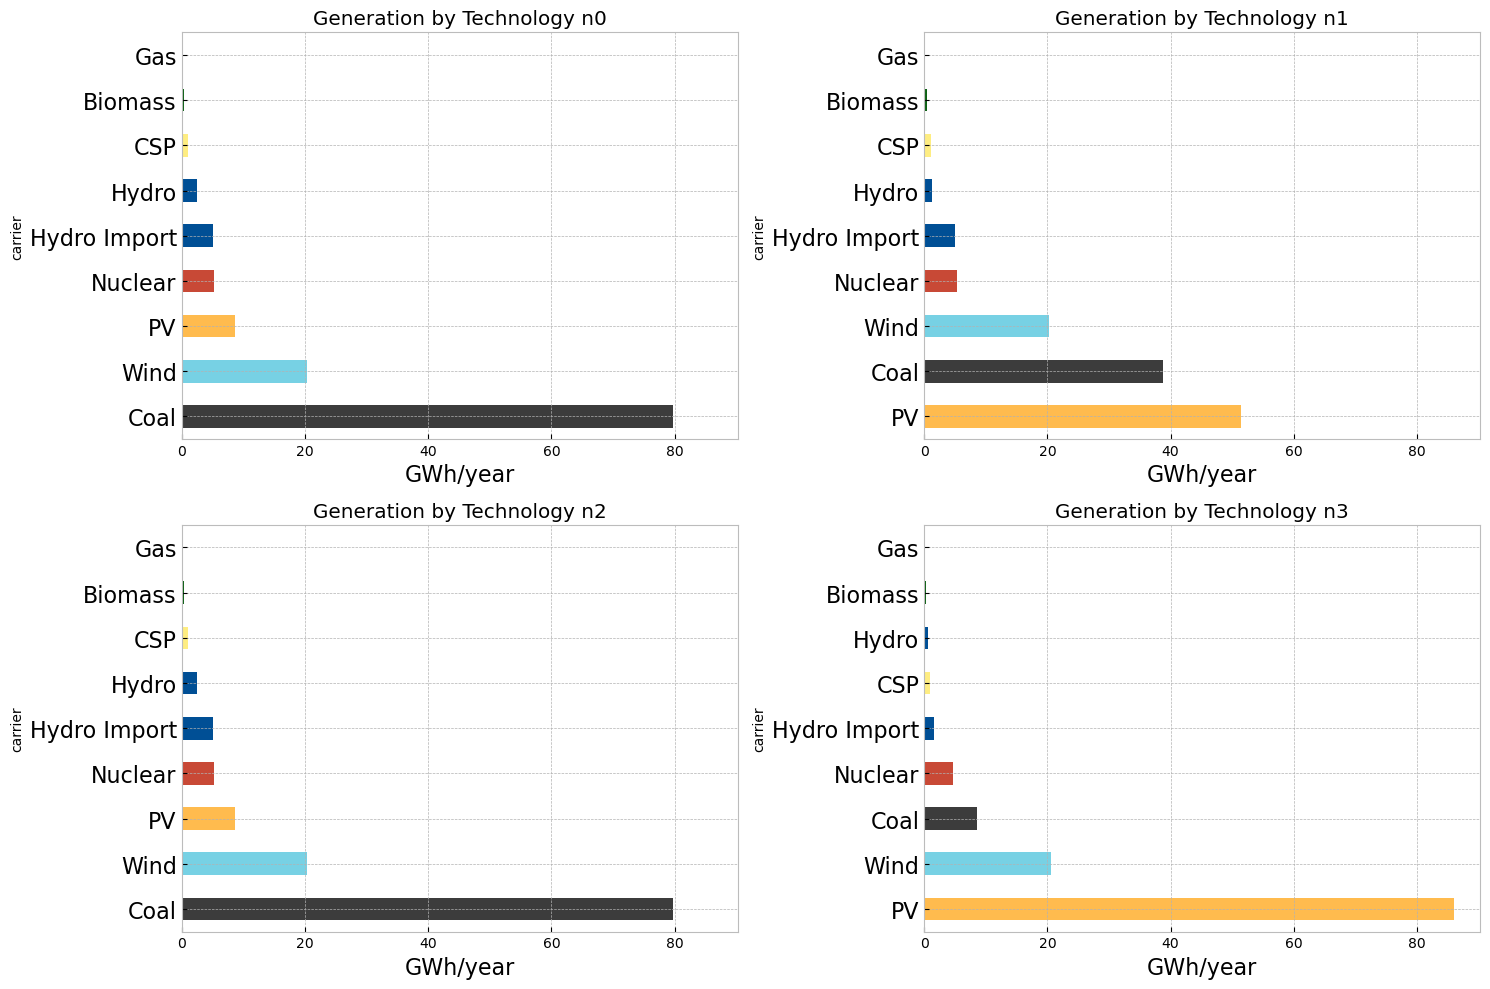

In [23]:
def plot_network_generation(network, ax, title):
    # Group by carrier and sum p_nom, divide by 1000 to convert to GW
    a = network.generators_t.p.sum().groupby(network.generators.carrier).sum().div(1e3)
    a = a[a != 0]

    carrier_order = ['onwind', 'solar', 'CSP', 'hydro', 'hydro-import', 'biomass', 'gas', 'nuclear', 'coal']
    a_sorted = a.loc[carrier_order].sort_values(ascending=False)

    # Create horizontal bar chart on the given ax
    a_sorted.plot.barh(color=[colors.get(carrier, '#333333') for carrier in a_sorted.index], ax=ax)
    ax.set_xlabel('GWh/year', fontsize=16)
    ax.set_title(title)
    ax.set_facecolor('white')
    ax.set_yticklabels([nice_names.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()], fontsize=16)

# Create a 2x2 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

plot_network_generation(n0, axes[0, 0], 'Generation by Technology n0')
plot_network_generation(n1, axes[0, 1], 'Generation by Technology n1')
plot_network_generation(n2, axes[1, 0], 'Generation by Technology n2')
plot_network_generation(n3, axes[1, 1], 'Generation by Technology n3')

# Find the global minimum and maximum for the x-axes
min_x = min(ax.get_xlim()[0] for ax in axes.flatten())
max_x = max(ax.get_xlim()[1] for ax in axes.flatten())

# Set the x limits for all the subplots to be the same
for ax in axes.flatten():
    ax.set_xlim(min_x, max_x)

plt.tight_layout()
plt.savefig('combined_plot.png', dpi=600, facecolor='white', bbox_inches='tight')
plt.show()


#### Generated Electricity per Day

In [10]:
# power (MWh) sum of 8760h /24 - MWh per day /1000 - GW per day
p_by_carrier_n0 = n0.generators_t.p.groupby(n0.generators.carrier, axis=1).sum()
p_by_carrier_n0 = p_by_carrier_n0.droplevel(level='period')
p_by_carrier_n0 = p_by_carrier_n0.drop(columns=["load_shedding"])

p_by_carrier_n1 = n1.generators_t.p.groupby(n0.generators.carrier, axis=1).sum()
p_by_carrier_n1 = p_by_carrier_n1.droplevel(level='period')
p_by_carrier_n1 = p_by_carrier_n1.drop(columns=["load_shedding"])

p_by_carrier_n2 = n2.generators_t.p.groupby(n0.generators.carrier, axis=1).sum()
p_by_carrier_n2 = p_by_carrier_n2.droplevel(level='period')
p_by_carrier_n2 = p_by_carrier_n2.drop(columns=["load_shedding"])

p_by_carrier_n3 = n3.generators_t.p.groupby(n0.generators.carrier, axis=1).sum()
p_by_carrier_n3 = p_by_carrier_n3.droplevel(level='period')
p_by_carrier_n3 = p_by_carrier_n3.drop(columns=["load_shedding"])

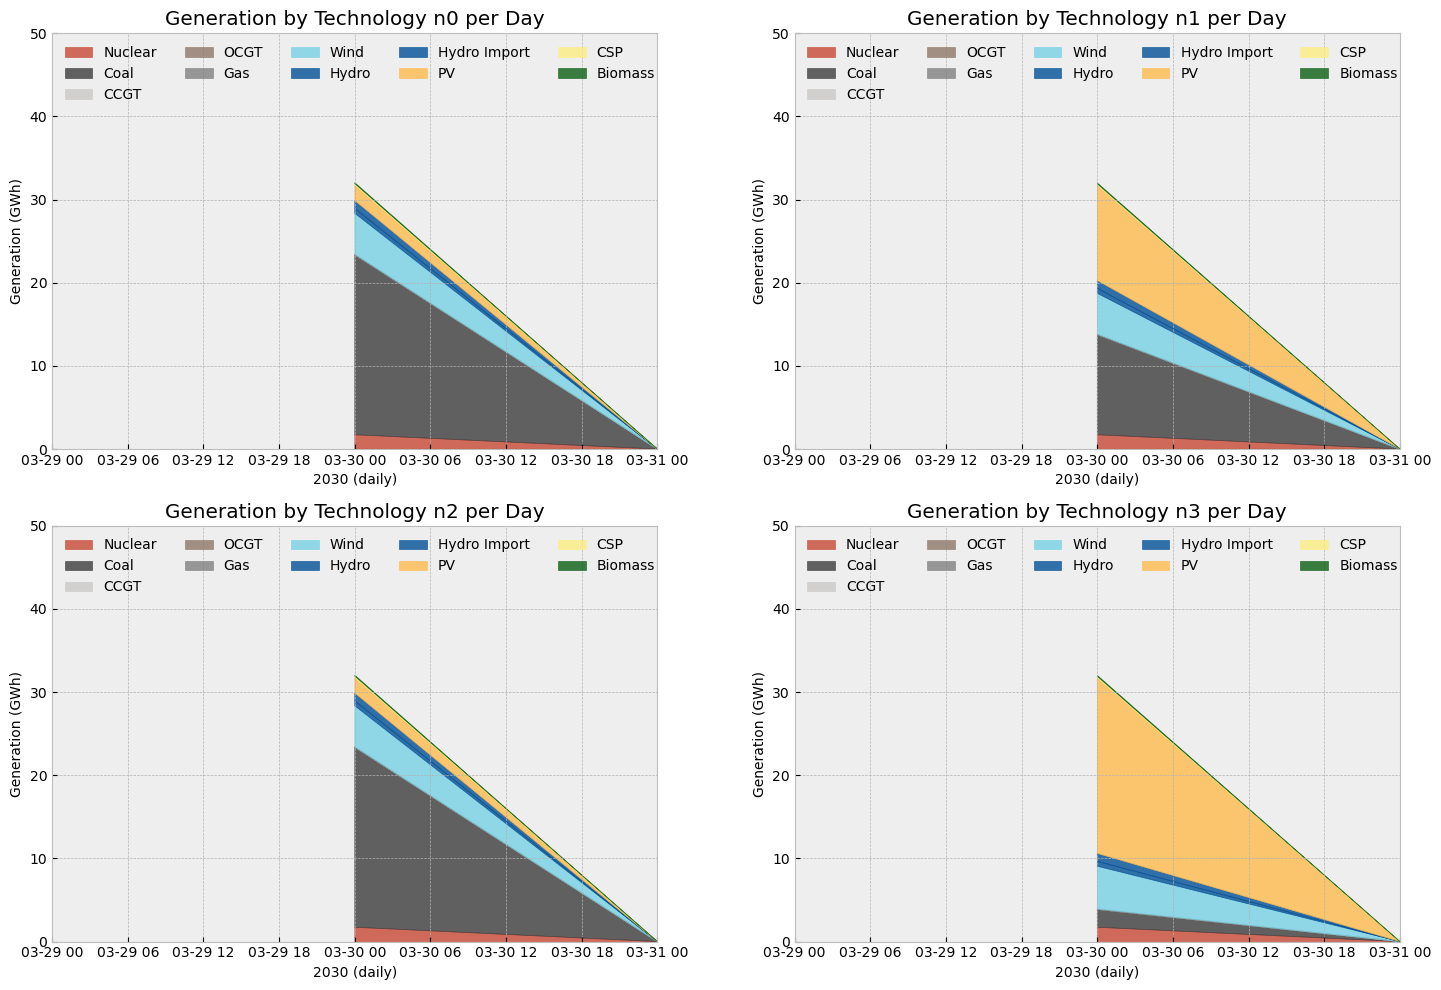

In [32]:
def plot_generation_per_day(p_by_carrier, ax, title):
    p_by_carrier_resampled = p_by_carrier.resample("D").sum()/1e3
    stacked = p_by_carrier_resampled.stack().reset_index()
    stacked.columns = ['week', 'carrier', 'GW']
    stacked = stacked.pivot(index='week', columns='carrier', values='GW')
    bottom = 0

    for carrier in nice_names:
        data = stacked[carrier]
        ax.fill_between(
            data.index, bottom, bottom + data, 
            color=colors[carrier], alpha=0.8, label=nice_names[carrier]
        )
        bottom += data

    ax.legend(ncol=5, loc="upper left", frameon=False)
    ax.set_xlabel("2030 (daily)")
    ax.set_ylabel("Generation (GWh)")
    ax.set_title(title)
    ax.set_ylim(0,50); #1000
    

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

plot_generation_per_day(p_by_carrier_n0, axes[0, 0], 'Generation by Technology n0 per Day')
plot_generation_per_day(p_by_carrier_n1, axes[0, 1], 'Generation by Technology n1 per Day')
plot_generation_per_day(p_by_carrier_n2, axes[1, 0], 'Generation by Technology n2 per Day')
plot_generation_per_day(p_by_carrier_n3, axes[1, 1], 'Generation by Technology n3 per Day')

# Set the common x limits
for ax in axes.flatten():
    ax.set_xlim(pd.Timestamp('2030-03-29'), pd.Timestamp('2030-03-31'))

plt.tight_layout()
plt.savefig('time_generation_combined.png', dpi=600, facecolor='white', bbox_inches='tight')
plt.show()


In [17]:
p_by_carrier_n0

carrier,CCGT,CSP,OCGT,biomass,coal,gas,hydro,hydro-import,nuclear,onwind,solar
timestep,,,,,,,,,,,
2030-03-30 06:00:00,0.0,159.760812,0.0,115.255520,2148.0,52.5,586.069789,950.886063,1725.166810,5142.055944,21135.356215
2030-06-29 12:00:00,0.0,186.655487,0.0,98.612417,2148.0,52.5,0.000000,0.000000,1131.736778,5512.550184,22802.535362
2030-09-28 18:00:00,0.0,294.425412,0.0,111.188453,2148.0,52.5,21.236549,635.199373,941.267673,5172.668804,21860.418336
2030-12-29 00:00:00,0.0,379.660931,0.0,0.000000,2148.0,52.5,0.000000,0.000000,927.000000,4698.720931,20097.390927


In [18]:
p_by_carrier_n1

carrier,CCGT,CSP,OCGT,biomass,coal,gas,hydro,hydro-import,nuclear,onwind,solar
timestep,,,,,,,,,,,
2030-03-30 06:00:00,0.0,159.760812,0.0,115.255520,12046.545485,52.5,585.643619,950.886063,1725.166810,4912.451588,11467.029560
2030-06-29 12:00:00,0.0,186.655487,0.0,98.612417,9994.339913,52.5,7.001598,1275.678196,1722.152155,5849.522031,12713.647367
2030-09-28 18:00:00,0.0,294.425412,0.0,111.188453,9147.146931,52.5,577.048636,1307.744037,941.267673,5273.894435,13556.525877
2030-12-29 00:00:00,0.0,399.643084,0.0,77.457023,7508.200931,52.5,65.000000,1431.462906,927.000000,4194.348777,13639.705118


In [19]:
p_by_carrier_n2

carrier,CCGT,CSP,OCGT,biomass,coal,gas,hydro,hydro-import,nuclear,onwind,solar
timestep,,,,,,,,,,,
2030-03-30 06:00:00,0.0,159.760812,0.0,115.255520,21651.331266,52.5,585.643619,950.886063,1725.166810,4927.296088,1872.236132
2030-06-29 12:00:00,0.0,186.655487,0.0,98.612417,20009.767775,52.5,605.582409,1275.678196,1722.152155,5853.852367,2095.308358
2030-09-28 18:00:00,0.0,294.425412,0.0,111.188453,20366.726428,52.5,577.048636,1307.744037,941.267673,5289.056760,2308.981787
2030-12-29 00:00:00,0.0,399.643084,0.0,77.457023,17652.694327,52.5,650.024000,1504.605382,927.000000,4197.673552,2344.988504


In [20]:
p_by_carrier_n3

carrier,CCGT,CSP,OCGT,biomass,coal,gas,hydro,hydro-import,nuclear,onwind,solar
timestep,,,,,,,,,,,
2030-03-30 06:00:00,0.0,159.760812,0.0,115.255520,2148.0,52.5,586.069789,950.886063,1725.166810,5142.055944,21135.356215
2030-06-29 12:00:00,0.0,186.655487,0.0,98.612417,2148.0,52.5,0.000000,0.000000,1131.736778,5512.550184,22802.535362
2030-09-28 18:00:00,0.0,294.425412,0.0,111.188453,2148.0,52.5,21.236549,635.199373,941.267673,5172.668804,21860.418336
2030-12-29 00:00:00,0.0,379.660931,0.0,0.000000,2148.0,52.5,0.000000,0.000000,927.000000,4698.720931,20097.390927


In [373]:
#Storage Unit

In [77]:
def get_storage_data(network):
    storage_p_sum = network.storage_units_t.p.sum()
    storage_p_sum = storage_p_sum.loc[storage_p_sum != 0]
    
    storage_p_nom_opt = network.storage_units.p_nom_opt
    storage_p_nom_opt = storage_p_nom_opt.loc[storage_p_nom_opt != 0]

    return storage_p_sum, storage_p_nom_opt

# Get the data for each network
a0, b0 = get_storage_data(n0)
a1, b1 = get_storage_data(n1)
a2, b2 = get_storage_data(n2)
a3, b3 = get_storage_data(n3)

# Combine storage_p_sum data
storage_p_sum_combined = pd.concat([a0, a1, a2, a3], axis=1, keys=['n0', 'n1', 'n2', 'n3'])
print("Storage p sum:")
print(storage_p_sum_combined)

print("\nSums of storage p sum:")
print(storage_p_sum_combined.sum())


storage_p_nom_opt_combined = pd.concat([b0, b1, b2, b3], axis=1, keys=['n0', 'n1', 'n2', 'n3'])
print("\nStorage p_nom_opt:")
print(storage_p_nom_opt_combined)

print("\nSums of storage p_nom_opt:")
print(storage_p_nom_opt_combined.sum())


Storage p sum:
                     n0          n1          n2          n3
StorageUnit                                                
Ingula      -486.431457 -559.232920 -486.431457 -563.384238
Drakensberg         NaN -342.563348         NaN -345.598899
Palmiet             NaN  -61.332569         NaN  -61.789910
Steenbras           NaN         NaN         NaN   -7.766648

Sums of storage p sum:
n0   -486.431457
n1   -963.128837
n2   -486.431457
n3   -978.539695
dtype: float64

Storage p_nom_opt:
                 n0      n1      n2      n3
StorageUnit                                
Drakensberg  1000.0  1000.0  1000.0  1000.0
Ingula       1332.0  1332.0  1332.0  1332.0
Palmiet       400.0   400.0   400.0   400.0
Steenbras     180.0   180.0   180.0   180.0

Sums of storage p_nom_opt:
n0    2912.0
n1    2912.0
n2    2912.0
n3    2912.0
dtype: float64


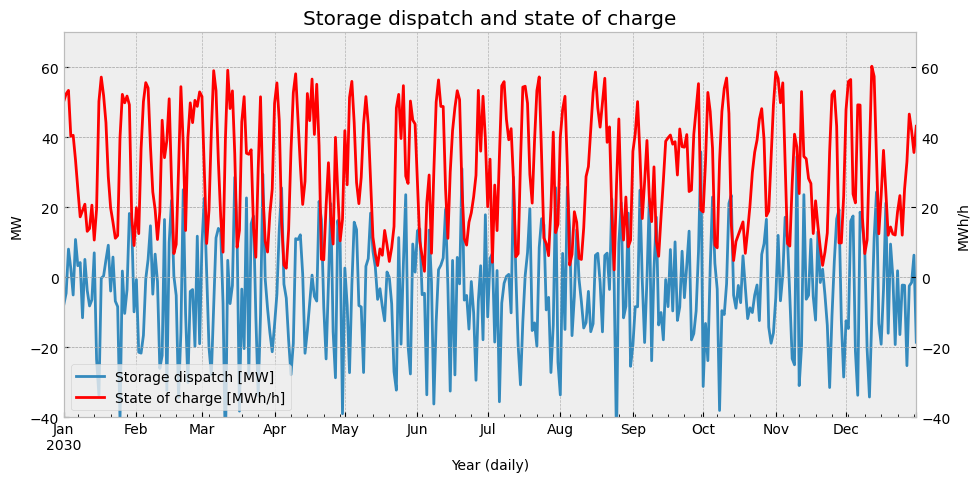

In [28]:
fig, ax = plt.subplots(figsize=(11, 5))

p_storage = n8.storage_units_t.p.sum(axis=1).div(1e3)
p_storage = p_storage.droplevel(level='period')
p_storage = p_storage.resample("D").sum()
state_of_charge = n8.storage_units_t.state_of_charge.sum(axis=1).div(1e3)/24
state_of_charge = state_of_charge.droplevel(level='period')
state_of_charge = state_of_charge.resample("D").sum()

p_storage.plot(label="Storage dispatch [MW]", ax=ax, ylabel="MW")

ax2 = ax.twinx()
ax2.plot(state_of_charge, label="State of charge [MWh/h]", color="red")
ax2.set_ylabel("MWh/h")

ax.set_ylim([-40, 70])
ax2.set_ylim([-40, 70])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)
ax.set_xlabel("Year (daily)")

ax.grid(True)
plt.title("Storage dispatch and state of charge")
plt.savefig("storage8.png")

#### Power Flow

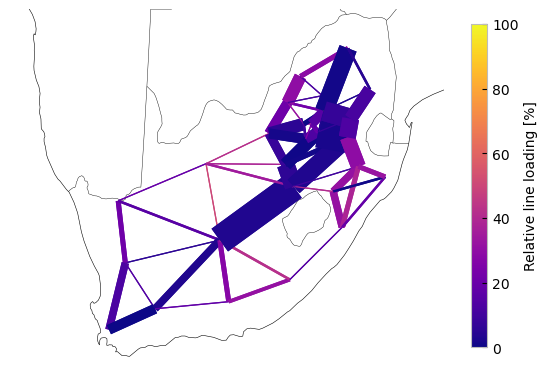

In [40]:
map_boundaries = [14, 34, -35, -22] 

line_loading = n0.lines_t.p0.iloc[0].abs() / n0.lines.s_nom_opt / n0.lines.s_max_pu * 100 # %

norm = plt.Normalize(vmin=0, vmax=100)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.EqualEarth())

n0.plot(
    ax=ax,
    bus_sizes=0,
    line_colors=line_loading,
    line_norm=norm,
    line_cmap='plasma',
    line_widths=n0.lines.s_nom_opt/ 1000,
    boundaries=map_boundaries
);

plt.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=norm),
    label='Relative line loading [%]',
    shrink=0.6
)

plt.savefig("network96.png")

### Transmission Line Expansion

In [41]:
(n0.lines.s_nom_opt).head(5)

Line
0    3574.952867
1    5362.429300
2     893.738217
3     893.738217
4     893.738217
Name: s_nom_opt, dtype: float64

In [347]:
unique_line_types = n96.lines.type.unique()
print("Unique line types:", unique_line_types)


Unique line types: ['Al/St 240/40 4-bundle 380.0']


In [42]:
# Before optimization
ac_lines_before = n0.lines.loc[n0.lines.type == "Al/St 240/40 4-bundle 380.0", "s_nom"]

# After optimization
ac_lines_after = n0.lines.loc[n0.lines.type == "Al/St 240/40 4-bundle 380.0", "s_nom_opt"]


In [43]:
print("Total AC line capacity before optimization:", ac_lines_before.sum())
print("Total AC line capacity after optimization:", ac_lines_after.sum())

Total AC line capacity before optimization: 0.0
Total AC line capacity after optimization: 566447.9302379999


# 3. Total Annual System Costs in billion

In [67]:
objectives = {
    'n0': n0.objective / 1e9,
    'n1': n1.objective / 1e9,
    'n2': n2.objective / 1e9,
    'n3': n3.objective / 1e9
}

# Converting the dictionary into a DataFrame
objectives_df = pd.DataFrame(list(objectives.items()), columns=['Network', 'Objective'])

# Print or display the DataFrame
print(objectives_df)

# If you want to save it to a CSV file
objectives_df.to_csv('total_costs.csv', index=False)


  Network   Objective
0      n0  186.733827
1      n1  195.003579
2      n2  186.733576
3      n3  213.878334


In [49]:
def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
    components = dict(
        Link=("p_nom", "p0"),
        Generator=("p_nom", "p"),
        StorageUnit=("p_nom", "p"),
        Store=("e_nom", "p"),
        Line=("s_nom", None),
        Transformer=("s_nom", None),
    )

    costs = {}
    for c, (p_nom, p_attr) in zip(
        n.iterate_components(components.keys(), skip_empty=False), components.values()
    ):
        if c.df.empty:
            continue
        if not existing_only:
            p_nom += "_opt"
        costs[(c.list_name, "capital")] = (
            (c.df[p_nom] * c.df.capital_cost).groupby(c.df.carrier).sum()
        )
        if p_attr is not None:
            p = c.pnl[p_attr].sum()
            if c.name == "StorageUnit":
                p = p.loc[p > 0]
            costs[(c.list_name, "marginal")] = (
                (p * c.df.marginal_cost).groupby(c.df.carrier).sum()
            )
    costs = pd.concat(costs)

    if flatten:
        assert opts is not None
        conv_techs = opts["conv_techs"]

        costs = costs.reset_index(level=0, drop=True)
        costs = costs["capital"].add(
            costs["marginal"].rename({t: t + " marginal" for t in conv_techs}),
            fill_value=0.0,
        )

    return costs

In [66]:
costs_df0 = aggregate_costs(n0, flatten=False, opts=None, existing_only=False)
costs_df1 = aggregate_costs(n1, flatten=False, opts=None, existing_only=False)
costs_df2 = aggregate_costs(n2, flatten=False, opts=None, existing_only=False)
costs_df3 = aggregate_costs(n3, flatten=False, opts=None, existing_only=False)

# Combine all the cost DataFrames into a single DataFrame
combined_costs = pd.concat([costs_df0, costs_df1, costs_df2, costs_df3], axis=1, keys=['n0', 'n1', 'n2', 'n3'])

# If you want to fill NaN with 0
combined_costs = combined_costs.fillna(0)

# Print or display the combined DataFrame
print(combined_costs)

combined_costs.to_csv('combined_costs.csv')

                                                n0            n1  \
                       carrier                                     
generators    capital  CCGT           0.000000e+00  0.000000e+00   
                       CSP            6.299739e+09  6.299739e+09   
                       OCGT           1.654772e+09  1.654772e+09   
                       biomass        1.928387e+09  1.928387e+09   
                       coal           4.478069e+10  4.478069e+10   
                       gas            6.429890e+08  6.429890e+08   
                       hydro          0.000000e+00  0.000000e+00   
                       hydro-import   0.000000e+00  0.000000e+00   
                       load_shedding  0.000000e+00  0.000000e+00   
                       nuclear        2.200698e+09  2.200698e+09   
                       onwind         1.591653e+10  1.591653e+10   
                       solar          4.634547e+09  4.346047e+10   
              marginal CCGT           0.000000e+

# 4. CO2 Emissions

In [412]:
#### Total CO2 emissions by the network (efficiency and fuel source)

In [60]:
# List of networks
networks = [n0, n1, n2, n3]

# Initialize an empty DataFrame to store the results
all_emissions = pd.DataFrame()

# Loop through the networks and calculate the emissions
for idx, network in enumerate(networks):
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    e = (emissions/network.generators.efficiency*network.generators.carrier.map(network.carriers.co2_emissions)).sum()
    e_carrier = e.groupby(network.generators.carrier).sum()/1e6
    e_carrier.rename(index={'OCGT': 'gas'}, inplace=True)
    e_carrier = e_carrier.groupby('carrier').sum()
    e_carrier = e_carrier.loc[lambda x: x != 0]
    
    all_emissions[f'n{idx}'] = e_carrier

# Compute the sum of emissions for each network and append it as a new row
all_emissions.loc['sum'] = all_emissions.sum()

# Print the result
print(all_emissions)


               n0       n1        n2        n3
carrier                                       
coal     0.073077  0.03346  0.073077  0.006399
gas      0.000030  0.00003  0.000030  0.000030
sum      0.073107  0.03349  0.073107  0.006429


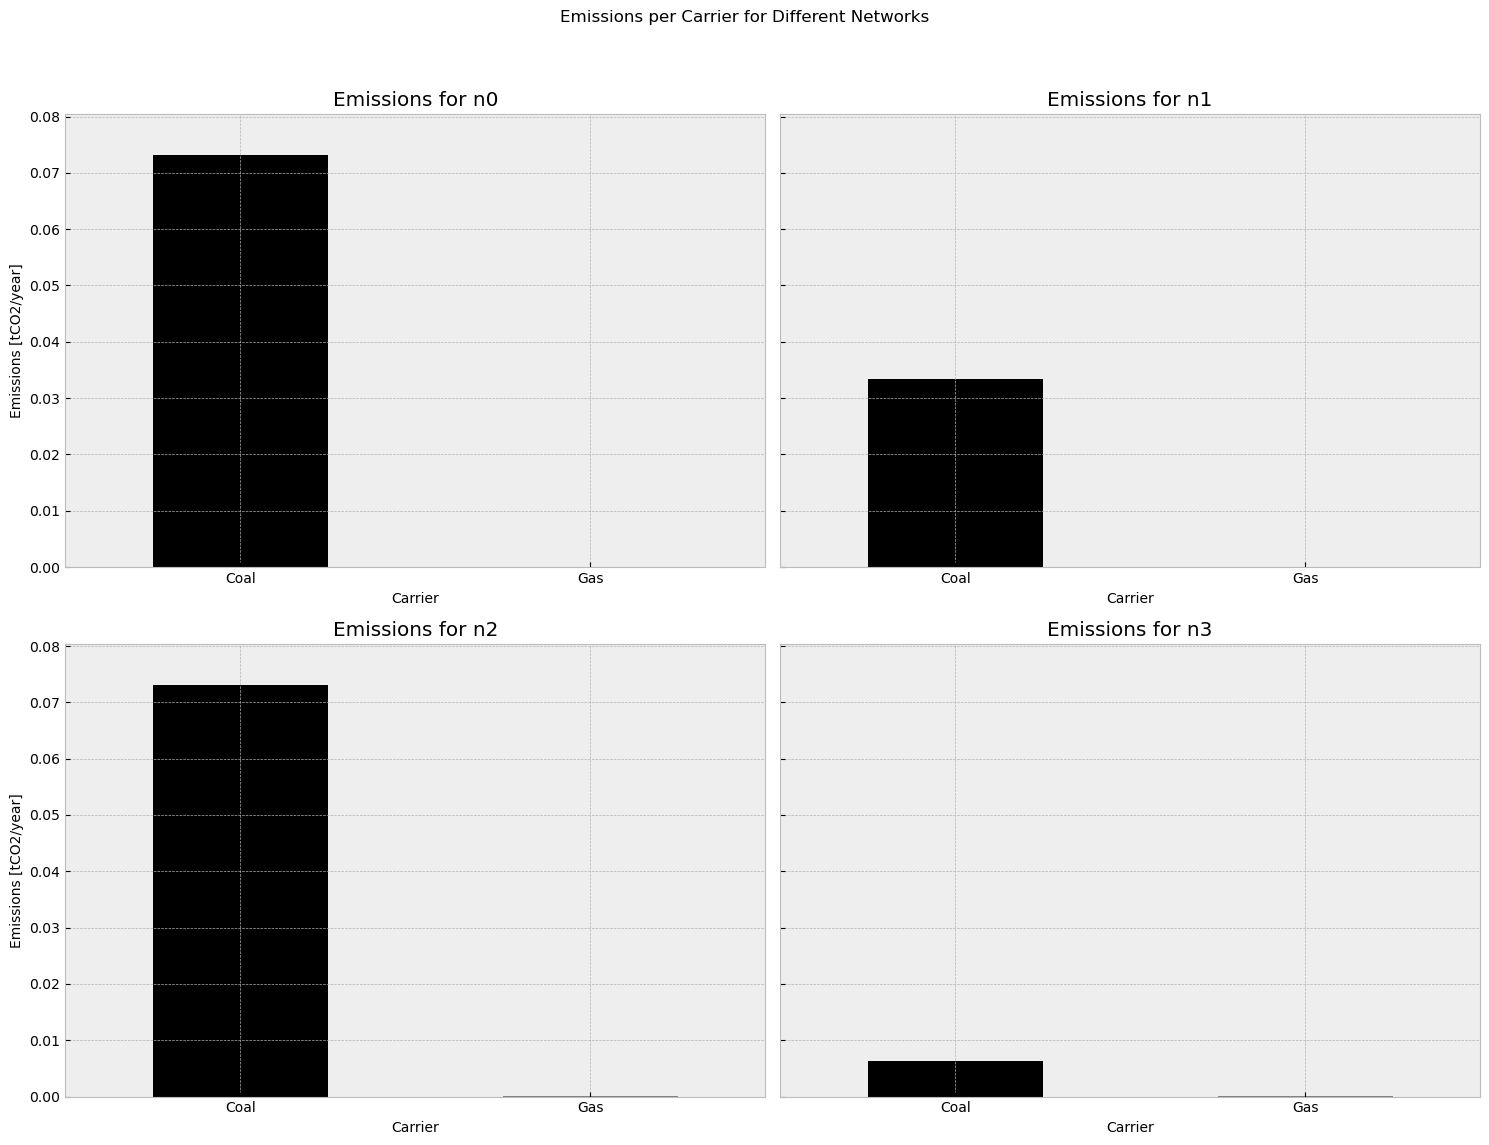

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
fig.suptitle('Emissions per Carrier for Different Networks')

networks = [n0, n1, n2, n3]

max_y = 0

# First, find the maximum y-value to set the same y-limit for all subplots
for network in networks:
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    e = (emissions/network.generators.efficiency*network.generators.carrier.map(network.carriers.co2_emissions)).sum()
    e_carrier = e.groupby(network.generators.carrier).sum()/1e6
    e_carrier.rename(index={'OCGT': 'gas'}, inplace=True)
    e_carrier = e_carrier.groupby('carrier').sum()
    e_carrier = e_carrier.loc[lambda x: x != 0]
    max_y = max(max_y, e_carrier.max()*1.1)

for idx, network in enumerate(networks):
    row = idx // 2
    col = idx % 2

    ax = axes[row, col]

    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    e = (emissions/network.generators.efficiency*network.generators.carrier.map(network.carriers.co2_emissions)).sum()
    e_carrier = e.groupby(network.generators.carrier).sum()/1e6
    e_carrier.rename(index={'OCGT': 'gas'}, inplace=True)
    e_carrier = e_carrier.groupby('carrier').sum()
    e_carrier = e_carrier.loc[lambda x: x != 0]

    e_carrier.plot(kind="bar", ax=ax, rot=0, color=["black", "grey"])
    ax.set_xlabel("Carrier")
    ax.set_ylabel("Emissions [tCO2/year]")
    ax.set_title(f"Emissions for n{idx}")
    ax.set_ylim(0, max_y) # set the same y-limit for all subplots

    ax.set_xticklabels([nice_names.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()], fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to make sure the titles fit well
plt.savefig("emissions_per_carrier_combined.png")
plt.show()


In [318]:
#### Plot total CO2 emissions per day

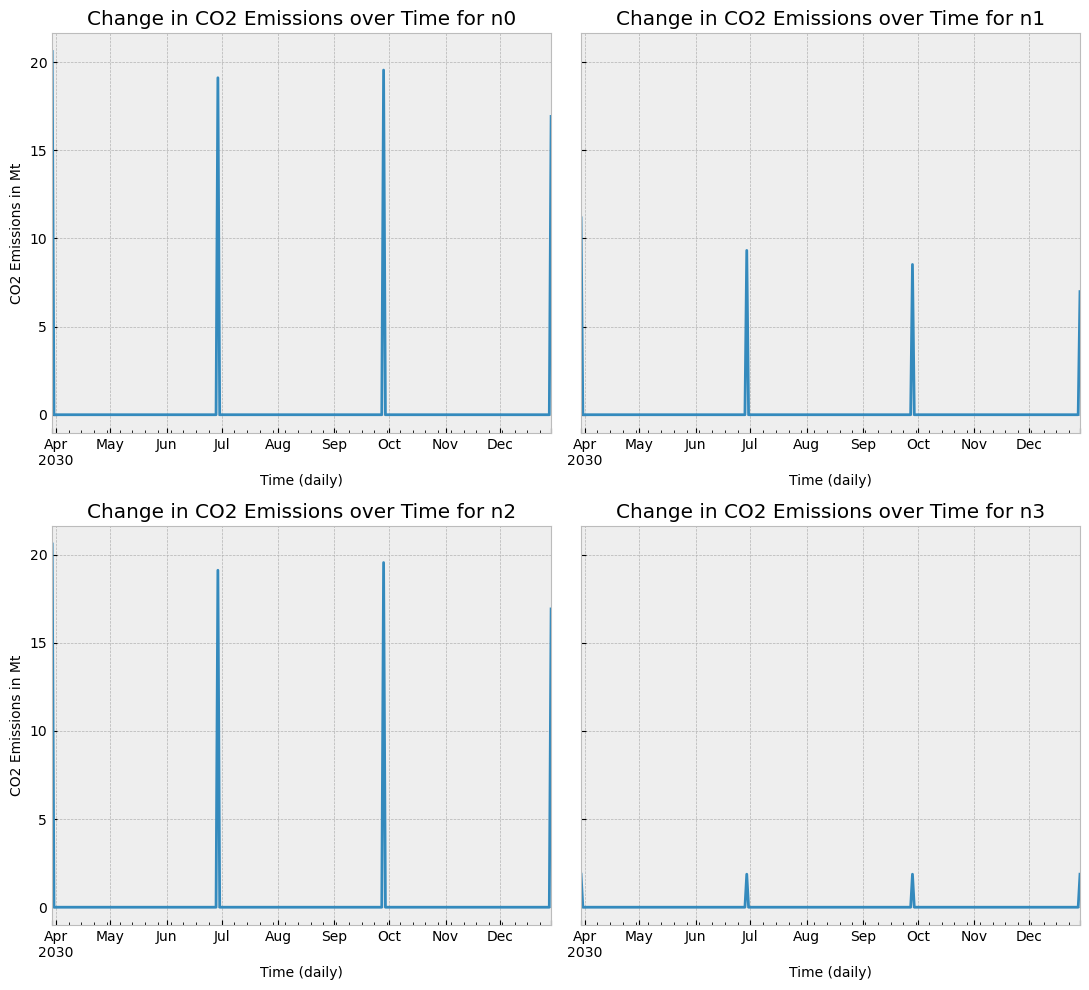

In [61]:
# List of networks
networks = [n0, n1, n2, n3]

# Create a subplot with 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(11, 10), sharey=True)
axes = axes.flatten()  # Flatten the 2x2 grid to access the axes easily

for idx, network in enumerate(networks):
    # Calculate emissions
    emissions = (network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)).sum(axis=1)
    emissions = emissions.droplevel(level='period')
    emissions = emissions.resample("D").sum()/1e3
    
    # Plot emissions for this network
    emissions.plot(ax=axes[idx], title=f'Change in CO2 Emissions over Time for n{idx}',
                   xlabel='Time (daily)', ylabel='CO2 Emissions in Mt')

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig("emissions_all_networks.png")

# Show plot
plt.show()
